In [224]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import DataLoader

<h1>Import MNIST + Process Data</h1>

In [225]:
transform = torchvision.transforms.ToTensor()
mnist_path = 'path/to/mnist/data'
mnist_train = torchvision.datasets.MNIST(root=mnist_path, train=True, transform=transform, download=True)
mnist_test = torchvision.datasets.MNIST(root=mnist_path, train=False, transform=transform)

In [226]:
data = train_test_split(mnist_train, test_size=0.1, shuffle=True)
mnist_train = data[0]
mnist_validation = data[1]

In [227]:
batch_size = 32

train_dataloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(mnist_validation, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

<h1>Plotting Helpers</h1>

In [228]:
def plot(xrange, training_loss, training_error, validation_error):
    training_loss = np.array(training_loss)
    training_error = np.array(training_error)
    validation_error = np.array(validation_error)
    x = np.arange(xrange)
    plt.plot(x, training_loss)
    plt.title("training loss")
    plt.xlabel("epoch iteration")
    plt.show()
    plt.figure()
    plt.plot(x, training_error)
    plt.title("training error")
    plt.xlabel("epoch iteration")
    plt.show()
    plt.figure()
    plt.plot(x, validation_error)
    plt.title("validation error")
    plt.xlabel("epoch iteration")
    plt.show()

def many_plots(xrange, tl_lst, te_lst, ve_lst, labels):
    titles = ["training loss", "training error", "validation error"]
    plots = [tl_lst, te_lst, ve_lst]

    for lst in plots:
        for i in range(len(lst)): 
            lst[i] = np.array(lst[i])
    x = np.arange(xrange)
    for lst in range(len(plots)):
        for i in range(len(tl_lst)):
            plt.plot(x, plots[lst][i], label=labels[i])
        plt.title(titles[lst])
        plt.xlabel("epoch iteration")
        plt.legend()
        plt.show()
        plt.figure()

<h1>Define CNN</h1>

In [229]:
epochs = 5
lr = 0.001 
momentum = 0.99

In [230]:
class ToyCNN(nn.Module):
    def __init__(self):
        super(ToyCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32,
                               kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, 
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.linear = nn.Sequential(
            nn.Linear(in_features=32*7*7, out_features=128), 
            nn.ReLU()
        )
        self.softmax = nn.Linear(in_features=128, out_features=10) #softmax taken care of in CrossEntropyLoss

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return self.softmax(x)

In [231]:
def calc_error(preds, actuals):
    batch = preds.size(0)
    preds = torch.argmax(preds, dim=1)
    wrong = (preds != actuals).sum().item()
    return wrong, batch

In [232]:
def train(model, criterion, optimizer, epochs=epochs, train_dataloader=train_dataloader, val_dataloader=val_dataloader):
    tl = [] # training loss 
    te = [] # training error
    ve = [] # validation error

    accum_wrong = 0
    accum_batch = 0
    with torch.no_grad():
        for _, (inputs, labels) in enumerate(train_dataloader):
            out = model(inputs)
            loss = criterion(out, labels)
            wrong, batch = calc_error(out, labels)
            accum_wrong += wrong
            accum_batch += batch
        tl.append(loss.item())
        te.append(accum_wrong/accum_batch)
        eval_accum_wrong = 0
        eval_accum_batch = 0
        for _, (eval_inputs, eval_labels) in enumerate(val_dataloader):
            eval_out = model(eval_inputs)
            eval_wrong, eval_batch = calc_error(eval_out, eval_labels)
            eval_accum_wrong += eval_wrong
            eval_accum_batch += eval_batch
        ve.append(eval_accum_wrong/eval_accum_batch)

    for _ in range(epochs): 
        accum_wrong = 0
        accum_batch = 0
        model.train()
        for _, (inputs, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            out = model(inputs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            wrong, batch = calc_error(out, labels)
            accum_wrong += wrong
            accum_batch += batch
        tl.append(loss.item())
        te.append(accum_wrong/accum_batch)
        eval_accum_wrong = 0
        eval_accum_batch = 0
        with torch.no_grad():
            for _, (eval_inputs, eval_labels) in enumerate(val_dataloader):
                eval_out = model(eval_inputs)
                eval_wrong, eval_batch = calc_error(eval_out, eval_labels)
                eval_accum_wrong += eval_wrong
                eval_accum_batch += eval_batch
            ve.append(eval_accum_wrong/eval_accum_batch)

    return tl, te, ve

<h1>Part 2: Original</h1>

In [233]:
model = ToyCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr, momentum=momentum)

In [234]:
tl, te, ve = train(model, criterion, optimizer)

In [235]:
print(tl)
print(te)
print(ve)

[2.3132164478302, 0.004261192865669727, 0.07014131546020508, 0.00184026756323874, 0.0031814363319426775, 0.0006279749795794487]
[0.8983333333333333, 0.12685185185185185, 0.018537037037037036, 0.014092592592592592, 0.009222222222222222, 0.008166666666666666]
[0.9023333333333333, 0.022166666666666668, 0.0195, 0.012333333333333333, 0.015666666666666666, 0.009166666666666667]


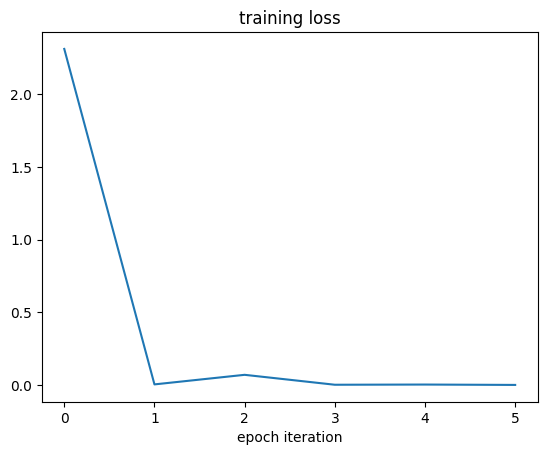

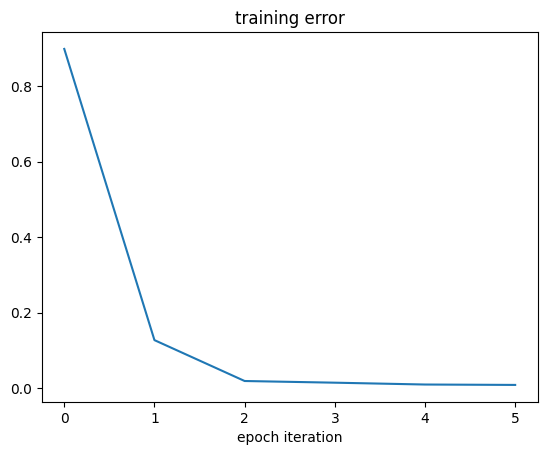

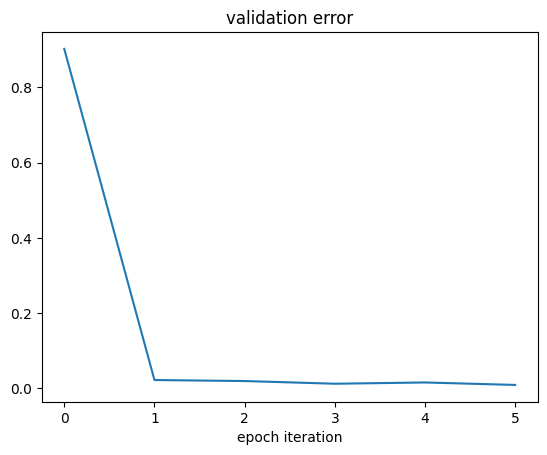

In [236]:
plot(epochs+1, tl, te, ve)

<h1>Part 3: Minibatch size</h1>

In [237]:
mini_batch_size = 8

mini_train_dataloader = DataLoader(mnist_train, batch_size=mini_batch_size, shuffle=True)
mini_val_dataloader = DataLoader(mnist_validation, batch_size=mini_batch_size, shuffle=True)
mini_test_dataloader = DataLoader(mnist_test, batch_size=mini_batch_size, shuffle=True)

In [238]:
mini_model = ToyCNN()
mini_criterion = nn.CrossEntropyLoss()
mini_optimizer = optim.SGD(mini_model.parameters(), lr = lr, momentum=momentum)

In [239]:
mini_tl, mini_te, mini_ve = train(mini_model, mini_criterion, mini_optimizer, train_dataloader=mini_train_dataloader, val_dataloader=mini_val_dataloader)

In [240]:
print(mini_tl)
print(mini_te)
print(mini_ve)

[2.285327911376953, 0.0003255917108617723, 0.07500381022691727, 0.00028166885022073984, 0.00034971878631040454, 0.0028952290304005146]
[0.8961666666666667, 0.060444444444444446, 0.017222222222222222, 0.011574074074074073, 0.010240740740740741, 0.008351851851851852]
[0.8875, 0.0205, 0.013666666666666667, 0.013833333333333333, 0.015, 0.012]


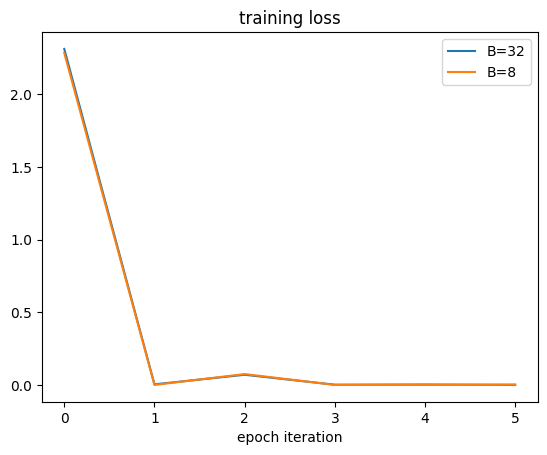

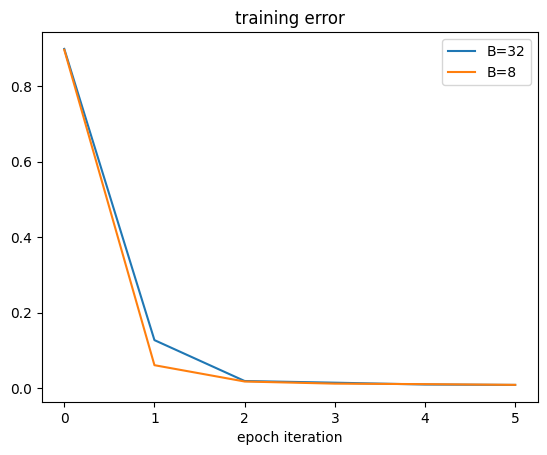

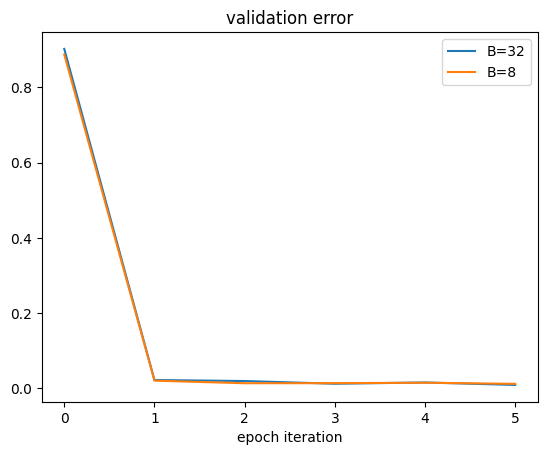

<Figure size 640x480 with 0 Axes>

In [241]:
many_plots(epochs+1, [tl, mini_tl], [te, mini_te], [ve, mini_ve], ["B=32", "B=8"])

<h1>Part 4: Momentum</h1>

In [242]:
momentum_model = ToyCNN()
momentum_criterion = nn.CrossEntropyLoss()
momentum_optimizer = optim.SGD(momentum_model.parameters(), lr = lr)

In [243]:
momentum_tl, momentum_te, momentum_ve = train(momentum_model, momentum_criterion, momentum_optimizer)

In [244]:
print(momentum_tl)
print(momentum_te)
print(momentum_ve)

[2.3029017448425293, 2.254763126373291, 1.9439754486083984, 0.5376109480857849, 0.4415052533149719, 0.25414469838142395]
[0.8976851851851851, 0.8307592592592593, 0.504537037037037, 0.2649444444444444, 0.14901851851851852, 0.11607407407407408]
[0.8981666666666667, 0.7241666666666666, 0.3288333333333333, 0.17933333333333334, 0.11516666666666667, 0.09733333333333333]


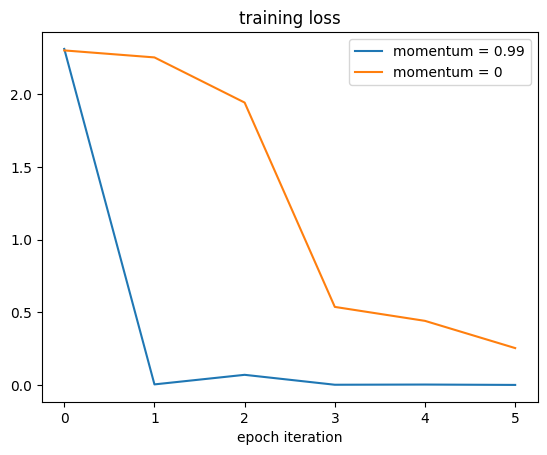

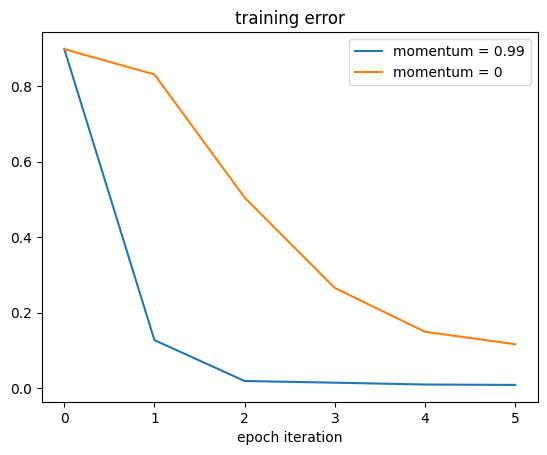

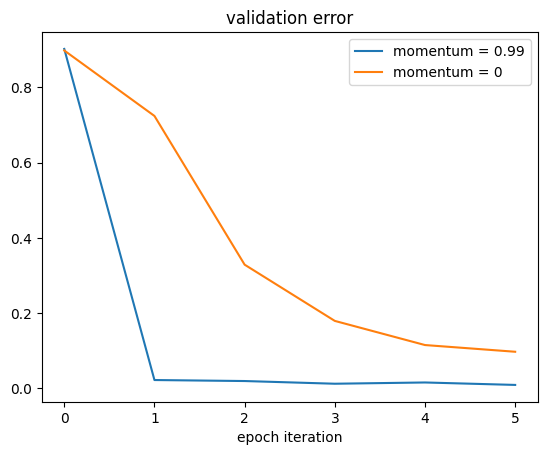

<Figure size 640x480 with 0 Axes>

In [245]:
many_plots(epochs+1, [tl, momentum_tl], [te, momentum_te], [ve, momentum_ve], ["momentum = 0.99", "momentum = 0"])

<h1>Part 5: Network Size</h1>

In [246]:
class DoubleCNN(nn.Module):
    def __init__(self):
        super(DoubleCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64,
                               kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, 
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.linear = nn.Sequential(
            nn.Linear(in_features=64*7*7, out_features=256), 
            nn.ReLU()
        )
        self.softmax = nn.Linear(in_features=256, out_features=10) #softmax taken care of in CrossEntropyLoss

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return self.softmax(x)

In [247]:
double_model = DoubleCNN()
double_criterion = nn.CrossEntropyLoss()
double_optimizer = optim.SGD(double_model.parameters(), lr = lr, momentum=momentum)

In [248]:
double_tl, double_te, double_ve = train(double_model, double_criterion, double_optimizer)

In [249]:
print(double_tl)
print(double_te)
print(double_ve)

[2.3013875484466553, 0.00267610140144825, 0.018029671162366867, 0.001285577192902565, 0.013182268477976322, 0.029266947880387306]
[0.9434814814814815, 0.10625925925925926, 0.01651851851851852, 0.010685185185185185, 0.007481481481481481, 0.006574074074074074]
[0.9365, 0.017833333333333333, 0.013333333333333334, 0.010833333333333334, 0.010833333333333334, 0.010833333333333334]


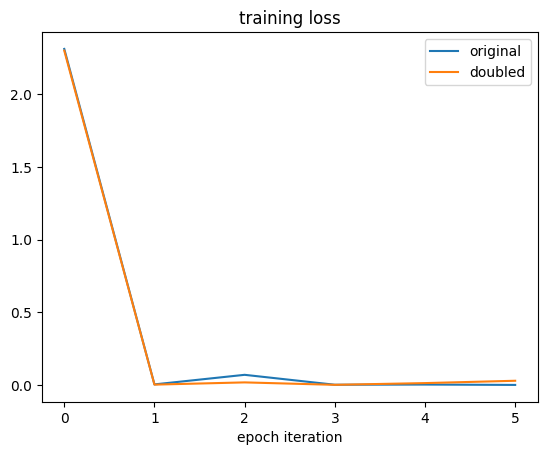

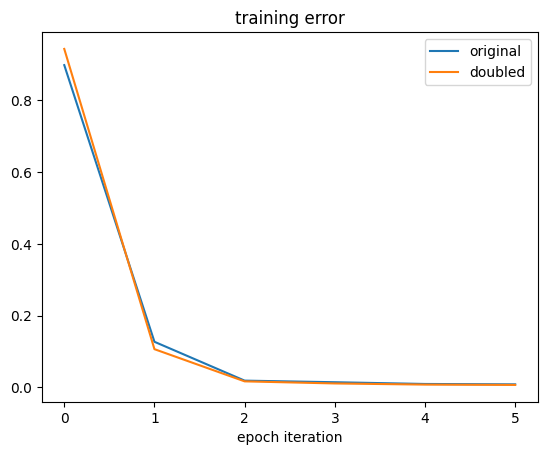

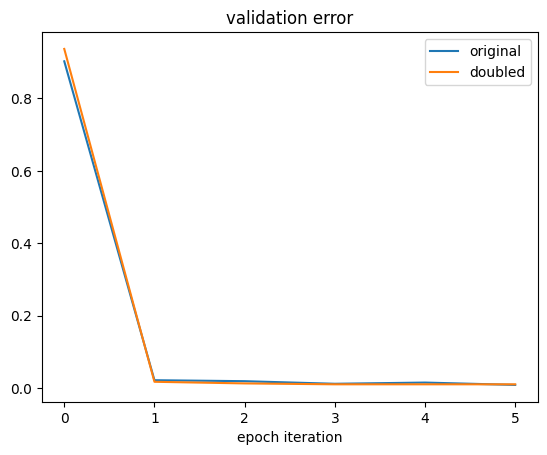

<Figure size 640x480 with 0 Axes>

In [250]:
many_plots(epochs+1, [tl, double_tl], [te, double_te], [ve, double_ve], ["original", "doubled"])

<h1>Part 6: Other Optimizer</h6>

In [251]:
adam_model = ToyCNN()
adam_criterion = nn.CrossEntropyLoss()
adam_optimizer = torch.optim.Adam(adam_model.parameters(), lr=0.001, betas=(0.99, 0.999))

In [252]:
adam_tl, adam_te, adam_ve = train(adam_model, adam_criterion, adam_optimizer)

In [253]:
print(adam_tl)
print(adam_te)
print(adam_ve)

[2.2866086959838867, 0.1815926879644394, 0.016393208876252174, 0.0008016707142814994, 0.22893357276916504, 0.013647370971739292]
[0.9248518518518518, 0.06577777777777778, 0.01911111111111111, 0.01162962962962963, 0.00874074074074074, 0.006851851851851852]
[0.9251666666666667, 0.0215, 0.013666666666666667, 0.010833333333333334, 0.012333333333333333, 0.0095]


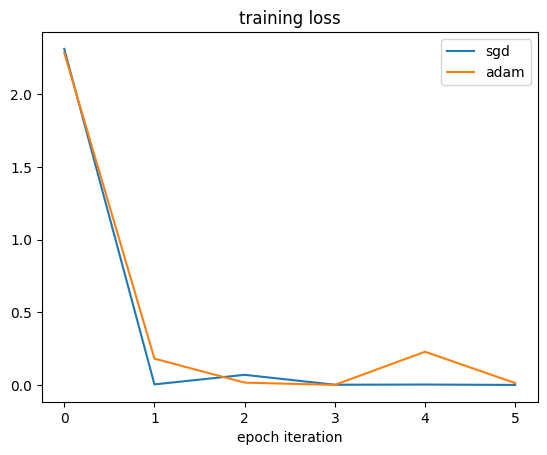

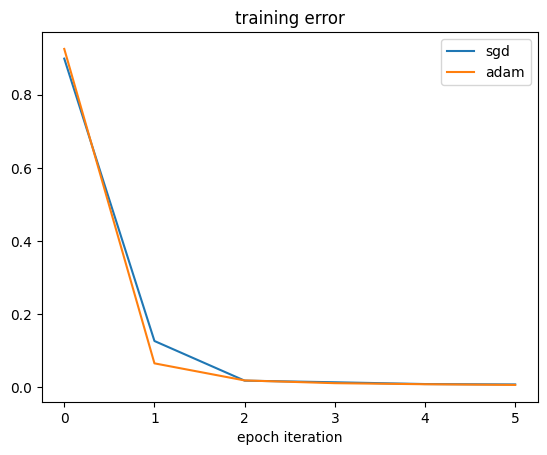

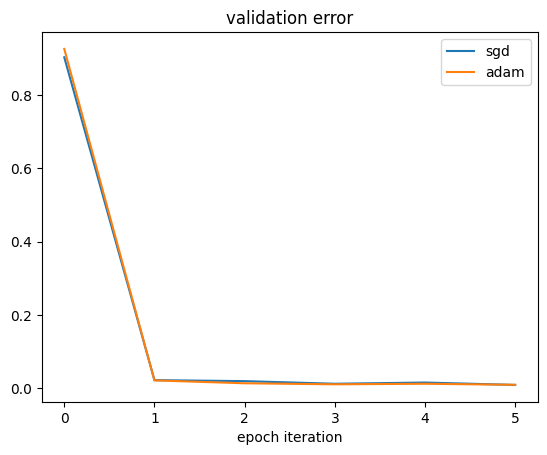

<Figure size 640x480 with 0 Axes>

In [254]:
many_plots(epochs+1, [tl, adam_tl], [te, adam_te], [ve, adam_ve],  ["sgd", "adam"])